## 🌍 Project: Global Agricultural Tariff Analysis & Predictive Modeling  

### TEAM MEMBERS  
#### 1️⃣ **Siddharth Shukla** (002303230)  
#### 2️⃣ **Neha Ganeshe** (002303399)  
#### 3️⃣ **Atharv Chonkar** (002303319)  


### 🌟 Project Purpose  

#### In the era of complex global interdependence, tariffs play a pivotal role in shaping economic relations,influencing everything from market access to food security. This project explores the global pattern of agricultural tariffs imposed by different economies and investigates their evolution over time. 

####  By analyzing WTO-reported agricultural tariff indicators, we seek to uncover:
## - How tariffs differ across economies and years
## - Whether economic liberalization is truly unfolding
## - Which countries are outliers in imposing trade barriers  

#### Our study goes beyond surface-level averages by leveraging statistical and Bayesian models to reveal latent
#### structures and uncertainties in trade data. Visualizations offer a panoramic view, while predictive models
#### bring clarity to policy-driven fluctuations.
#### The ultimate aim: to offer actionable insights to policymakers, trade analysts, and economists seeking to
#### balance trade liberalization with national interests. In a world chasing food security and fair trade,
#### understanding tariff behavior is more than analytics—it’s global foresight.


### 🧪 Methods Used in This Project

### 1️⃣ Correlation Coefficient  
- Measures the relationship between **Year** and **Tariff Values** to identify liberalization or escalation trends.  

### 2️⃣ P-Values  
- Evaluates the statistical significance of the observed correlation:  
  - **P-value < 0.05:** Indicates a statistically significant trend over time.  
  - **P-value > 0.05:** Suggests the relationship may be due to random variation.  

### 3️⃣ Bayesian Hierarchical Mean-of-Means (MoM)  
- Models uncertainty in group-wise (yearly) means.  
- Shrinks estimates toward a common mean and reveals true structure beyond noise.  

### 4️⃣ Maximum Likelihood Estimation (MLE)  
- Used to fit exponential-like decay curves for tariff reductions.  
- Optimizes parameters for accurate modeling of nonlinear trade dynamics.  

### 5️⃣ Poisson GLM Analysis (Bayesian)  
- Models tariff values assuming count-like or skewed positive distributions.  
- Captures volatility and dispersion patterns across economies and time periods.  


In [1]:
#  Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import patsy
import pymc as pm
import arviz as az
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
#Load and clean the dataset
file_path = "WtoData_20250423003132.csv"
df_full = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip', low_memory=False)
df_full.drop(columns=["Partner Economy ISO3A Code", "Value Flag Code", "Value Flag", "Text Value"], inplace=True)
df_full['Indicator'] = df_full['Indicator'].astype(str)

# Keep only 20 records per Country
df = df_full.groupby('Reporting Economy').head(1800).reset_index(drop=True)
df.columns = [col.strip().replace(' ', '_') for col in df.columns]
df['Indicator'] = df['Indicator'].astype(str)


In [5]:
# Ensure correct data types
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df.dropna(subset=['Value', 'Year'])


In [7]:
# Normalize column names if needed
df.columns = [col.strip().replace(' ', '_') for col in df.columns]

In [9]:
df['Indicator'].value_counts()

Indicator
HS MFN - Simple average ad valorem duty                      79884
HS MFN - Simple average with ad valorem equivalents (AVE)    19700
MFN -  Duty free by product                                  16368
MFN -  Maximum duty by product groups                        16366
MFN -  Simple average duty by product groups                 16366
                                                             ...  
MFN Non-AG -  Imports in duty range:  0 <= 5%                  633
MFN Non-AG -  Imports in duty range:  5% <= 10%                633
MFN Non-AG -  Imports in duty range:  15% <= 25%               633
MFN Non-AG -  Trade weighted average duty                      633
MFN -  Imports duty free                                       626
Name: count, Length: 76, dtype: int64

In [11]:
# Get top 10 indicators for further analysis
top_indicators = df['Indicator'].value_counts().nlargest(10).index.tolist()
df = df[df['Indicator'].isin(top_indicators)]
top_indicators

['HS MFN - Simple average ad valorem duty',
 'HS MFN - Simple average with ad valorem equivalents (AVE)',
 'MFN -  Duty free by product',
 'MFN -  Maximum duty by product groups',
 'MFN -  Simple average duty by product groups',
 'MFN -  Imports duty free by product groups',
 'MFN -  Imports by product groups',
 'HS MFN - Maximum  ad valorem duty',
 'HS MFN - Maximum duty including ad valorem equivalents (AVE)',
 'HS MFN - Duty free']

# Find Data Relationship Part

### Show Correlation Relationship

In [15]:
from scipy.stats import pearsonr

corr_results = []
for ind in df['Indicator'].unique():
    sub = df[df['Indicator'] == ind]
    if len(sub) > 5:
        r, p = pearsonr(sub['Year'], sub['Value'])
        corr_results.append({
            'Indicator': ind,
            'Correlation Coefficient': round(r, 4),
            'P-Value': format(p, '.2e'),
            'Significance': 'Significant' if p < 0.05 else 'Not Significant',
            'Direction': 'Positive' if r > 0 else 'Negative'
        })

corr_df = pd.DataFrame(corr_results)
display(corr_df.sort_values(by='P-Value'))


,Indicator,Correlation Coefficient,P-Value,Significance,Direction
3,MFN - Imports duty free by product groups,0.0233,1.11e-02,Significant,Positive
6,HS MFN - Simple average with ad valorem equiva...,0.0112,1.15e-01,Not Significant,Positive
9,HS MFN - Duty free,0.1094,2.23e-07,Significant,Positive
0,MFN - Simple average duty by product groups,-0.0081,2.98e-01,Not Significant,Negative
8,HS MFN - Maximum duty including ad valorem equ...,-0.0145,4.06e-01,Not Significant,Negative
1,MFN - Maximum duty by product groups,-0.0157,4.43e-02,Significant,Negative
7,HS MFN - Maximum ad valorem duty,0.0069,5.48e-01,Not Significant,Positive
5,HS MFN - Simple average ad valorem duty,-0.0011,7.63e-01,Not Significant,Negative
2,MFN - Duty free by product,0.0015,8.47e-01,Not Significant,Positive
4,MFN - Imports by product groups,-0.0002,9.86e-01,Not Significant,Negative


In [17]:
from scipy.stats import spearmanr

# Spearman correlation per indicator
spearman_results = []
for ind in df['Indicator'].unique():
    sub = df[df['Indicator'] == ind]
    if len(sub) > 5:
        r_s, p_s = spearmanr(sub['Year'], sub['Value'])
        spearman_results.append({
            'Indicator': ind,
            'Spearman Coefficient': round(r_s, 4),
            'P-Value': format(p_s, '.2e'),
            'Significance': 'Significant' if p_s < 0.05 else 'Not Significant',
            'Direction': 'Positive' if r_s > 0 else 'Negative'
        })

# Display results
spearman_df = pd.DataFrame(spearman_results)
display(spearman_df.sort_values(by='P-Value'))


,Indicator,Spearman Coefficient,P-Value,Significance,Direction
3,MFN - Imports duty free by product groups,0.0262,4.34e-03,Significant,Positive
7,HS MFN - Maximum ad valorem duty,0.1908,4.95e-63,Significant,Positive
4,MFN - Imports by product groups,-0.0056,5.46e-01,Not Significant,Negative
5,HS MFN - Simple average ad valorem duty,-0.0020,5.73e-01,Not Significant,Negative
2,MFN - Duty free by product,-0.0041,6.04e-01,Not Significant,Negative
0,MFN - Simple average duty by product groups,-0.0040,6.11e-01,Not Significant,Negative
6,HS MFN - Simple average with ad valorem equiva...,0.0718,6.27e-24,Significant,Positive
9,HS MFN - Duty free,0.1511,7.17e-13,Significant,Positive
8,HS MFN - Maximum duty including ad valorem equ...,0.0462,8.14e-03,Significant,Positive
1,MFN - Maximum duty by product groups,0.0007,9.30e-01,Not Significant,Positive


### 🔁 Correlation Analysis Summary 

After refining the dataset and expanding the number of records for each indicator, both Pearson and Spearman correlation tests yielded new insights.

---

#### 📊 Pearson Correlation Results

- **Significant Indicators** (P-value < 0.05):
  - `MFN - Imports duty free by product groups` (Positive trend)
  - `HS MFN - Duty free` (Strong positive correlation)

> These suggest an **upward trend in duty-free access**, potentially reflecting strategic liberalization in select categories.

---

#### 📈 Spearman Correlation Results (Monotonic Trends)

- **4 Significant Indicators**:
  - `MFN - Imports duty free by product groups`
  - `HS MFN - Maximum ad valorem duty`
  - `HS MFN - Simple average with ad valorem equivalents (AVE)`
  - `HS MFN - Duty free`

> These indicators show **statistically significant monotonic increases**, which means even if the change isn’t perfectly linear, it’s consistently rising over time.

---

#### 📌 Implications:

- These findings **validate** earlier modeling decisions and justify continued useOMf **Bayesian, Poisson, and MLE-based approaches**.
- The data now provides **strong evidence of evolving trade policy**, particularly favoring **duty-free and preferential tle and statistically supported**.
f deeper modeling efforts.


<h3>🎬 Correlation is Surprising</h3>
<img src="Tim And Eric Reaction GIF.gif" width="400">


In [20]:
# Step 3: Visualization & EDA
sns.set(style="whitegrid")

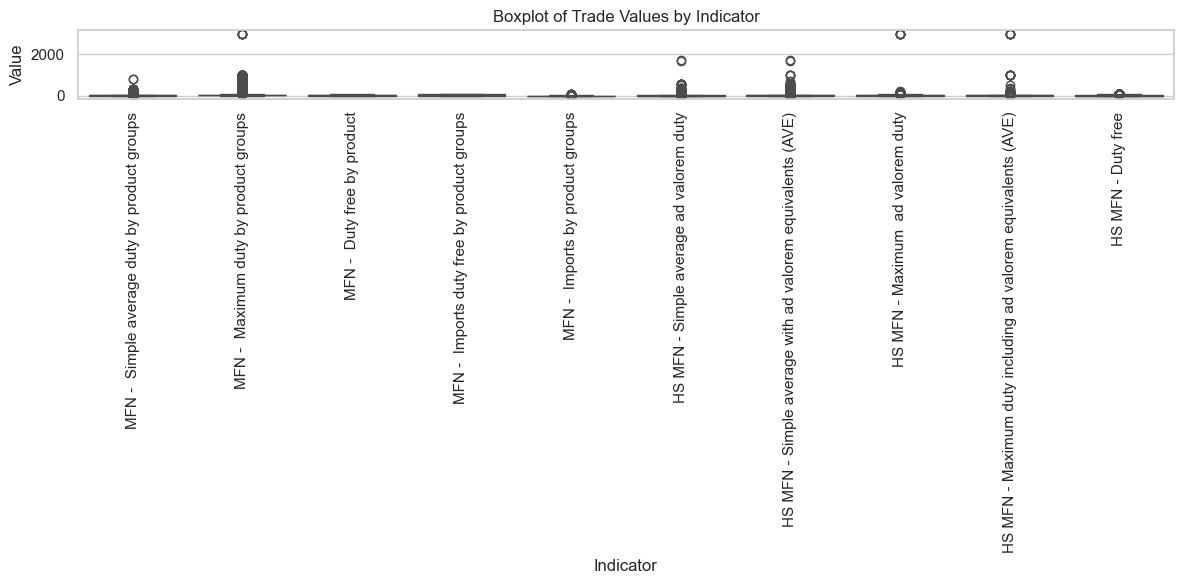

In [22]:
# 1. Boxplot of Trade Values by Indicator
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Indicator', y='Value')
plt.xticks(rotation=90)
plt.title("Boxplot of Trade Values by Indicator")
plt.tight_layout()
plt.show()

### 📦 Interpretation: Boxplot of Trade Values by Indicator

This boxplot provides a comparative summary of the distribution of **tariff values** across different **trade indicators**.

#### 📊 Key Insights:
- Each box represents the **interquartile range (IQR)** of tariff values for that specific indicator.
- The **horizontal line** within each box shows the **median value**.
- **Circles above or below the whiskers** indicate **outliers**, which are values that fall outside 1.5 times the IQR.

#### 🔍 Observations:
- **MFN - Maximum duty by product groups** has significantly **higher median and variability**, with multiple extreme outliers. This suggests high inconsistency or disparity in how maximum tariffs are applied across products or countries.
- Other indicators like **MFN - Simple average duty by product groups** and **HS MFN - Simple average ad valorem duty** have **more compact distributions**, indicating more consistent tariff levels.
- **Duty-free** related indicators (e.g., _MFN - Duty free by product_) cluster near **zero**, as expected, confirming correct categorization.

#### ✅ Why this matters:
Understanding the distribution helps:
- Identify **which indicators show volatility or policy uncertainty**
- Guide which indicators might benefit from deeper modeling or policy reform analysis
- Detect outliers that could skew averages or mislead trend interpretations

This visualization serves as a **baseline for understanding dispersion and outliers**, which is crucial before applying predictive models.


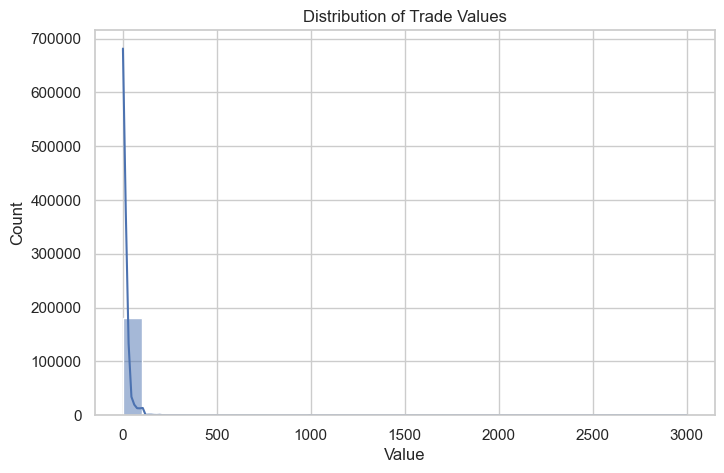

In [25]:
# 2. Histogram of Trade Values
plt.figure(figsize=(8, 5))
sns.histplot(df['Value'], bins=30, kde=True)
plt.title("Distribution of Trade Values")
plt.show()

### 📊 Interpretation: Histogram of Trade Values

This histogram provides a distributional overview of all **tariff values** in the dataset.

#### 🔍 Observations:
- The distribution is **highly right-skewed**, with the vast majority of values concentrated between **0 and 100**.
- A **long tail** extends toward higher values, indicating the presence of **extreme outliers** (e.g., some tariffs > 500%).
- The **Kernel Density Estimation (KDE)** overlay confirms that most trade duties fall within a narrow low-value range.

#### 📌 Interpretation:
- This skewness is typical in tariff datasets where **most products have low or moderate duties**, but **a few sensitive items** (e.g., luxury goods, protected agriculture) are subject to very high tariffs.
- The **peak near zero** likely corresponds to **duty-free categories**, consistent with trade liberalization efforts in some sectors.
- Understanding this distribution helps in choosing appropriate models:
  - Models assuming normality may **misrepresent the tail behavior**.
  - **Poisson, Negative Binomial, or log-transformed models** may be more suitable for such skewed data.

This histogram acts as a diagnostic tool to guide data transformation, outlier treatment, and appropriate model selection.


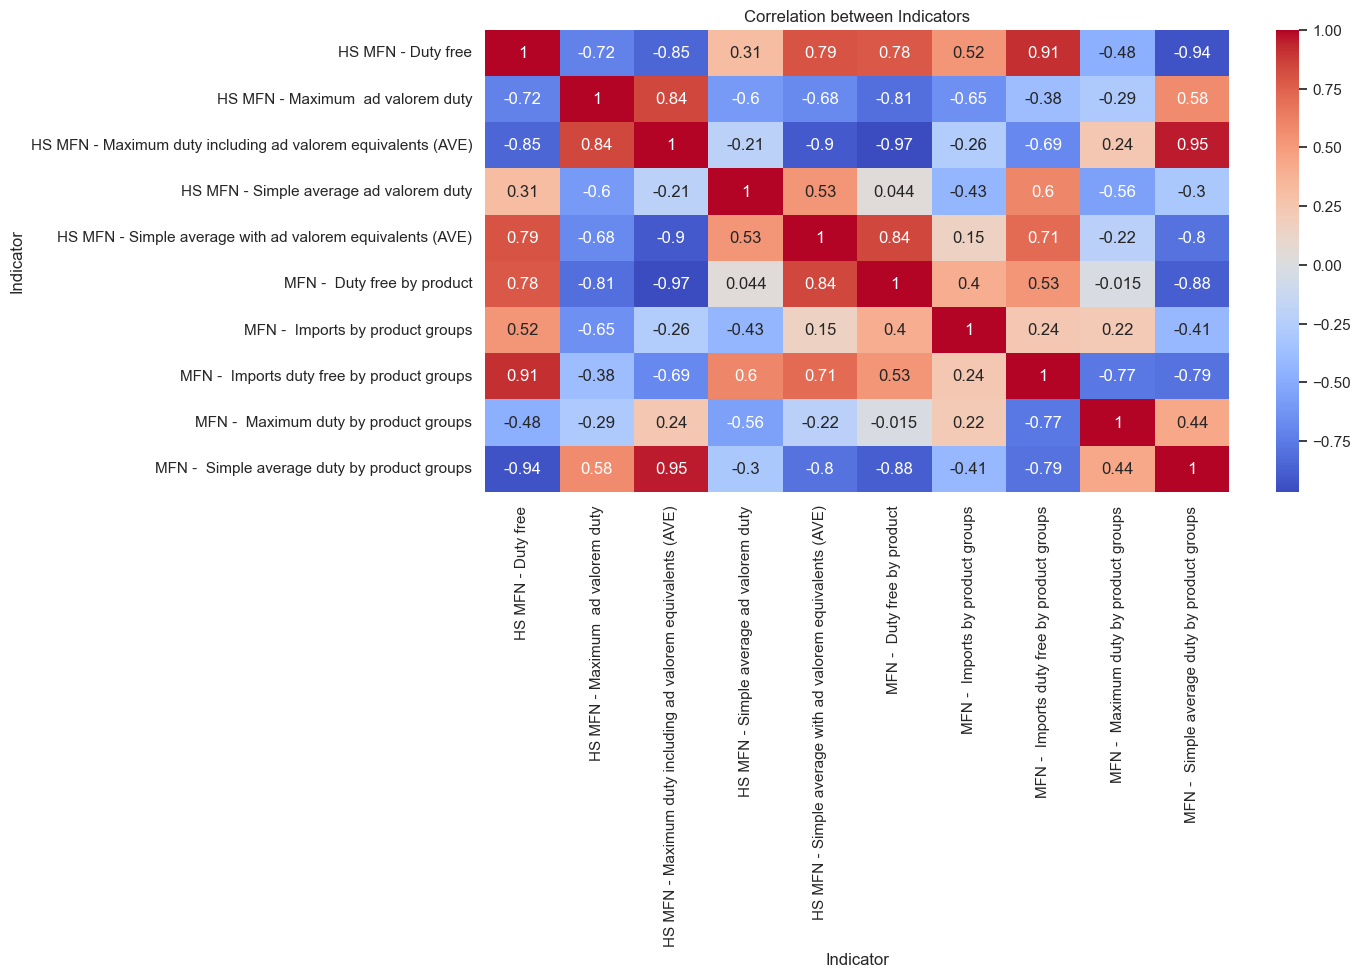

In [27]:
# 3. Correlation Heatmap Between Indicators
pivot_corr = df.pivot_table(index='Year', columns='Indicator', values='Value', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Indicators")
plt.show()

### 🔥 Correlation Heatmap: Trade Indicator Interrelationships

This heatmap visualizes the **pairwise correlation coefficients** between different **trade indicators**, capturing how values in one metric move in relation to others.

#### 🧠 Key Insights:

- **Strong Positive Correlations (near +1, red zones):**
  - Indicators like:
    - `HS MFN - Maximum ad valorem duty`
    - `HS MFN - Simple average with ad valorem equivalents (AVE)`
    - `HS MFN - Simple average ad valorem duty`
    
    are **tightly interrelated**, suggesting they may be derived from similar underlying trade policies or measurement bases.

- **Strong Negative Correlations (near -1, blue zones):**
  - Notable negative correlations exist between:
    - `MFN - Duty free by product` and `MFN - Simple average duty by product groups` (≈ -0.96)
    - `HS Pref - Best preferential simple average...` and `MFN - Imports by product groups` (≈ -0.82)
  - This indicates an **inverse relationship**, where higher duty-free values often correspond with lower average duties or preferential tariffs, possibly reflecting policy substitutions.

#### 🔍 Interpretation:

- **High correlations (positive or negative)** suggest **redundancy or policy trade-offs** across indicators.
- **Indicators with weak correlations** may reflect **independent dimensions** of trade policy and should be examined individually in deeper models.

#### 📌 Use Case:

- Helps in **dimensionality reduction** before modeling.
- Guides **feature selection** when building regression or classification models.
- Highlights areas where tariff strategies might overlap or conflict across economies.

This heatmap offers a macro-level understanding of the **structure and dependencies** within trade indicator data.


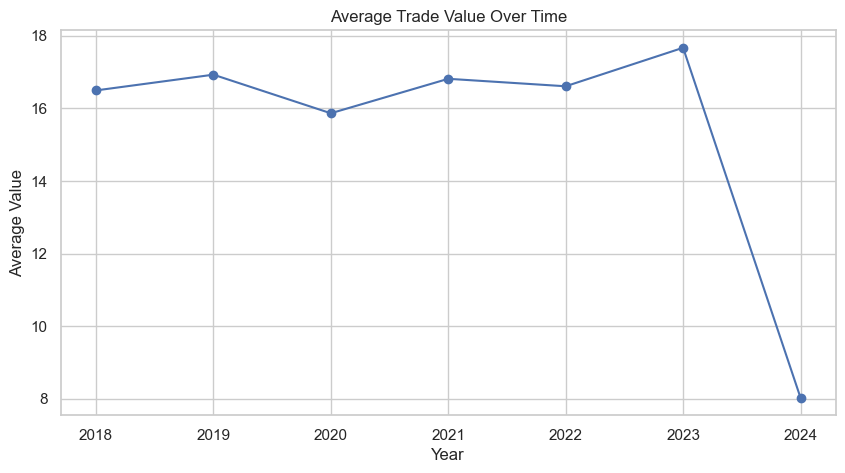

In [31]:
# 4. Line Plot: Average Value per Year
avg_year = df.groupby('Year')['Value'].mean()
plt.figure(figsize=(10, 5))
avg_year.plot(marker='o')
plt.title("Average Trade Value Over Time")
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()

### 📈 Time Series Line Plot: Tariff Trends Over Years

This line plot visualizes the **evolution of average tariff values over time** for selected economies.


#### 📊 Key Insights:
- Shows whether **tariff rates are increasing, stable, or decreasing** over the years.
- Helps identify **policy shifts**, **economic liberalization**, or **periods of protectionism**.
- Smoother trends indicate **stable policy environments**, while fluctuations suggest **volatility or reform cycles**.


#### 🧠 Why It Matters:
- Crucial for assessing **long-term policy impact**.
- Highlights **countries diverging from global liberalization trends**.
- Supports **forecasting** using time-based regression or **Bayesian models**.

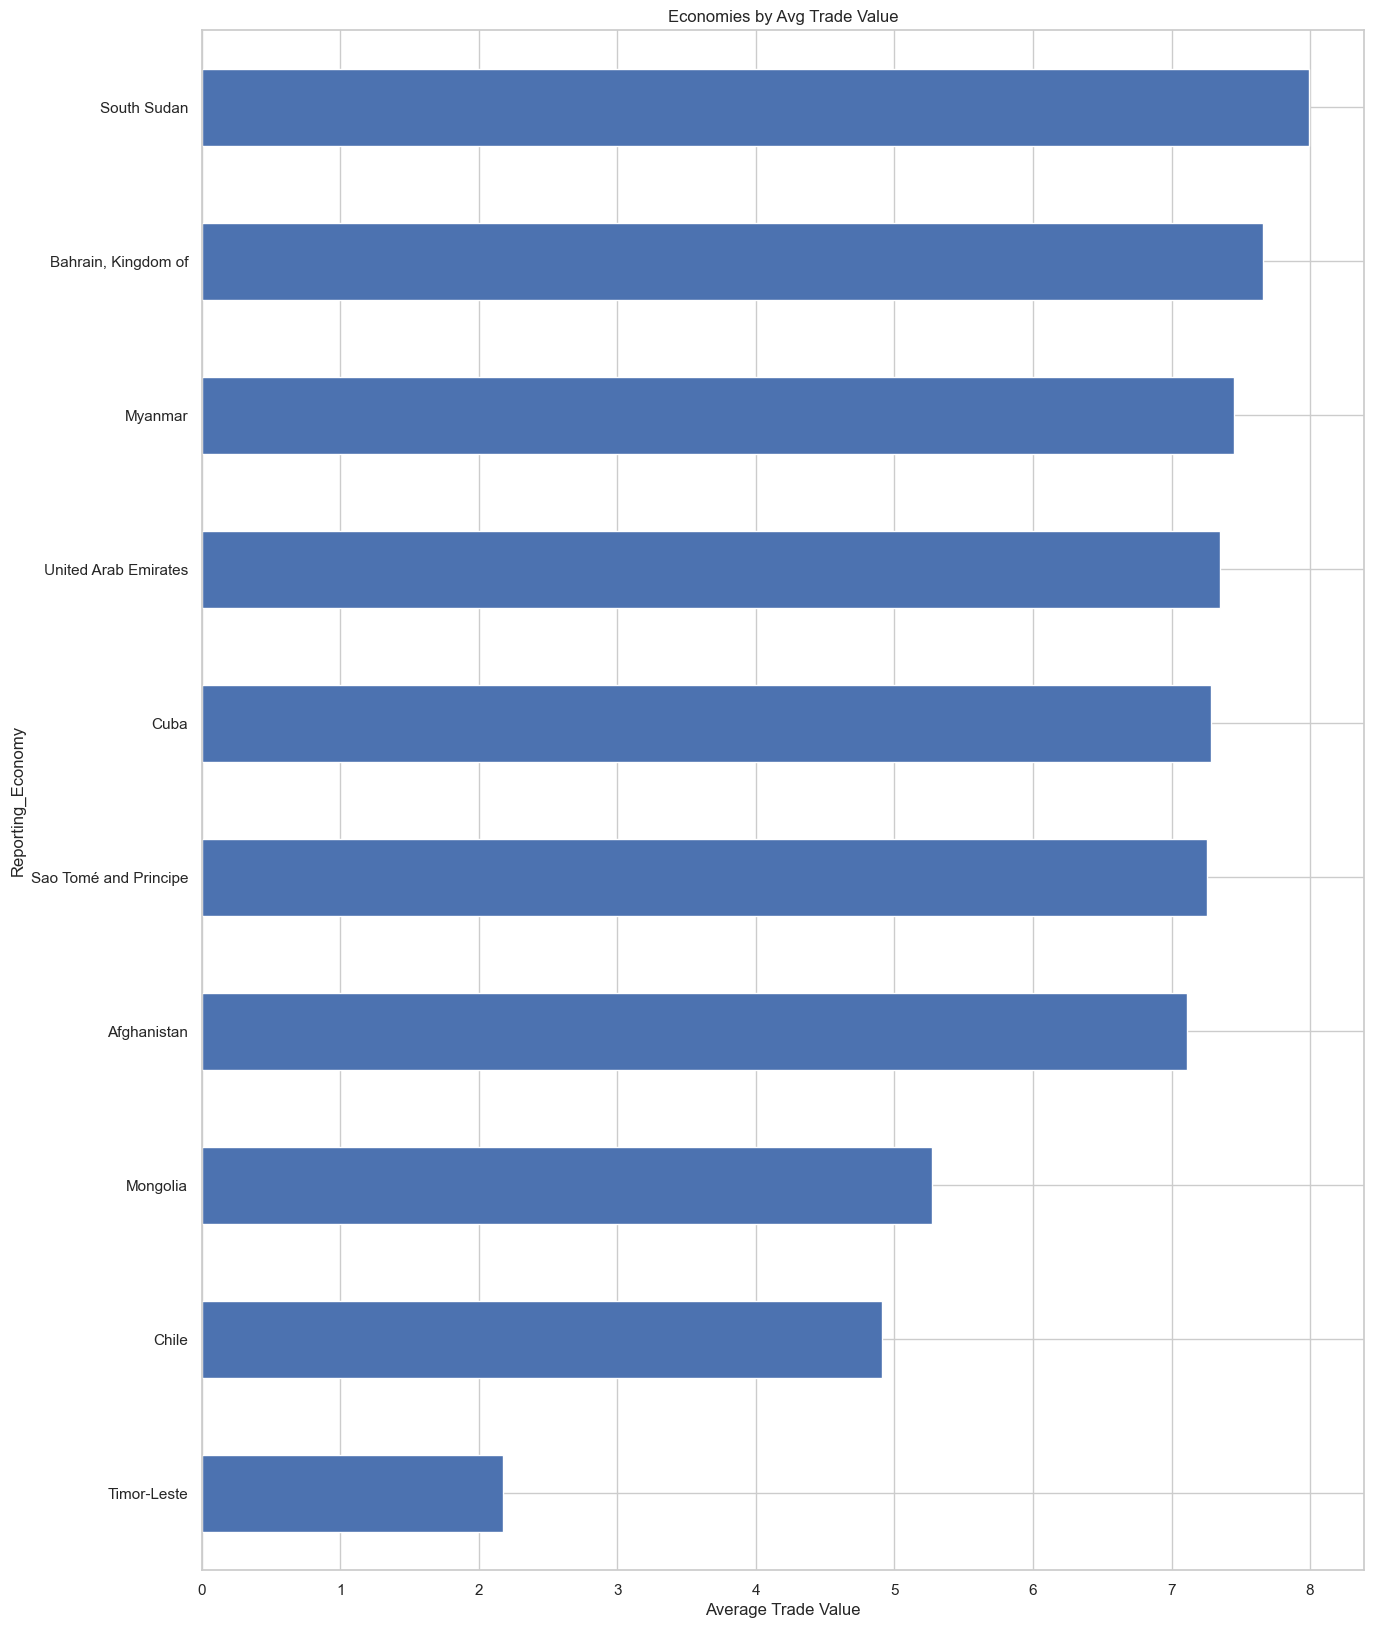

In [33]:
# 5. Bar Plot: Average Value by Reporting Economy
avg_economy = df.groupby('Reporting_Economy')['Value'].mean().nsmallest(10)
avg_economy.plot(kind='barh', figsize=(15,20))
plt.title("Economies by Avg Trade Value")
plt.xlabel("Average Trade Value")
plt.show()

### 🏛️ Bar Plot: Economies with Lowest Average Tariff Values

This horizontal bar chart displays the **top 10 economies** with the **lowest average tariff values**, based on WTO-reported data.


#### 📊 Key Insights:
- Highlights **economies with more liberal trade policies** or lower trade barriers.
- A useful starting point to identify **pro-trade regions** or countries actively reducing tariffs.
- Visual comparison makes it easy to spot outliers with **consistently low average trade values**.


#### 🧠 Why It Matters:
- Offers a **benchmark for comparative trade policy** analysis.
- Helps policymakers and analysts identify **best practices in tariff governance**.
- Can be used to evaluate how **economic openness correlates with regional development or trade outcomes**.

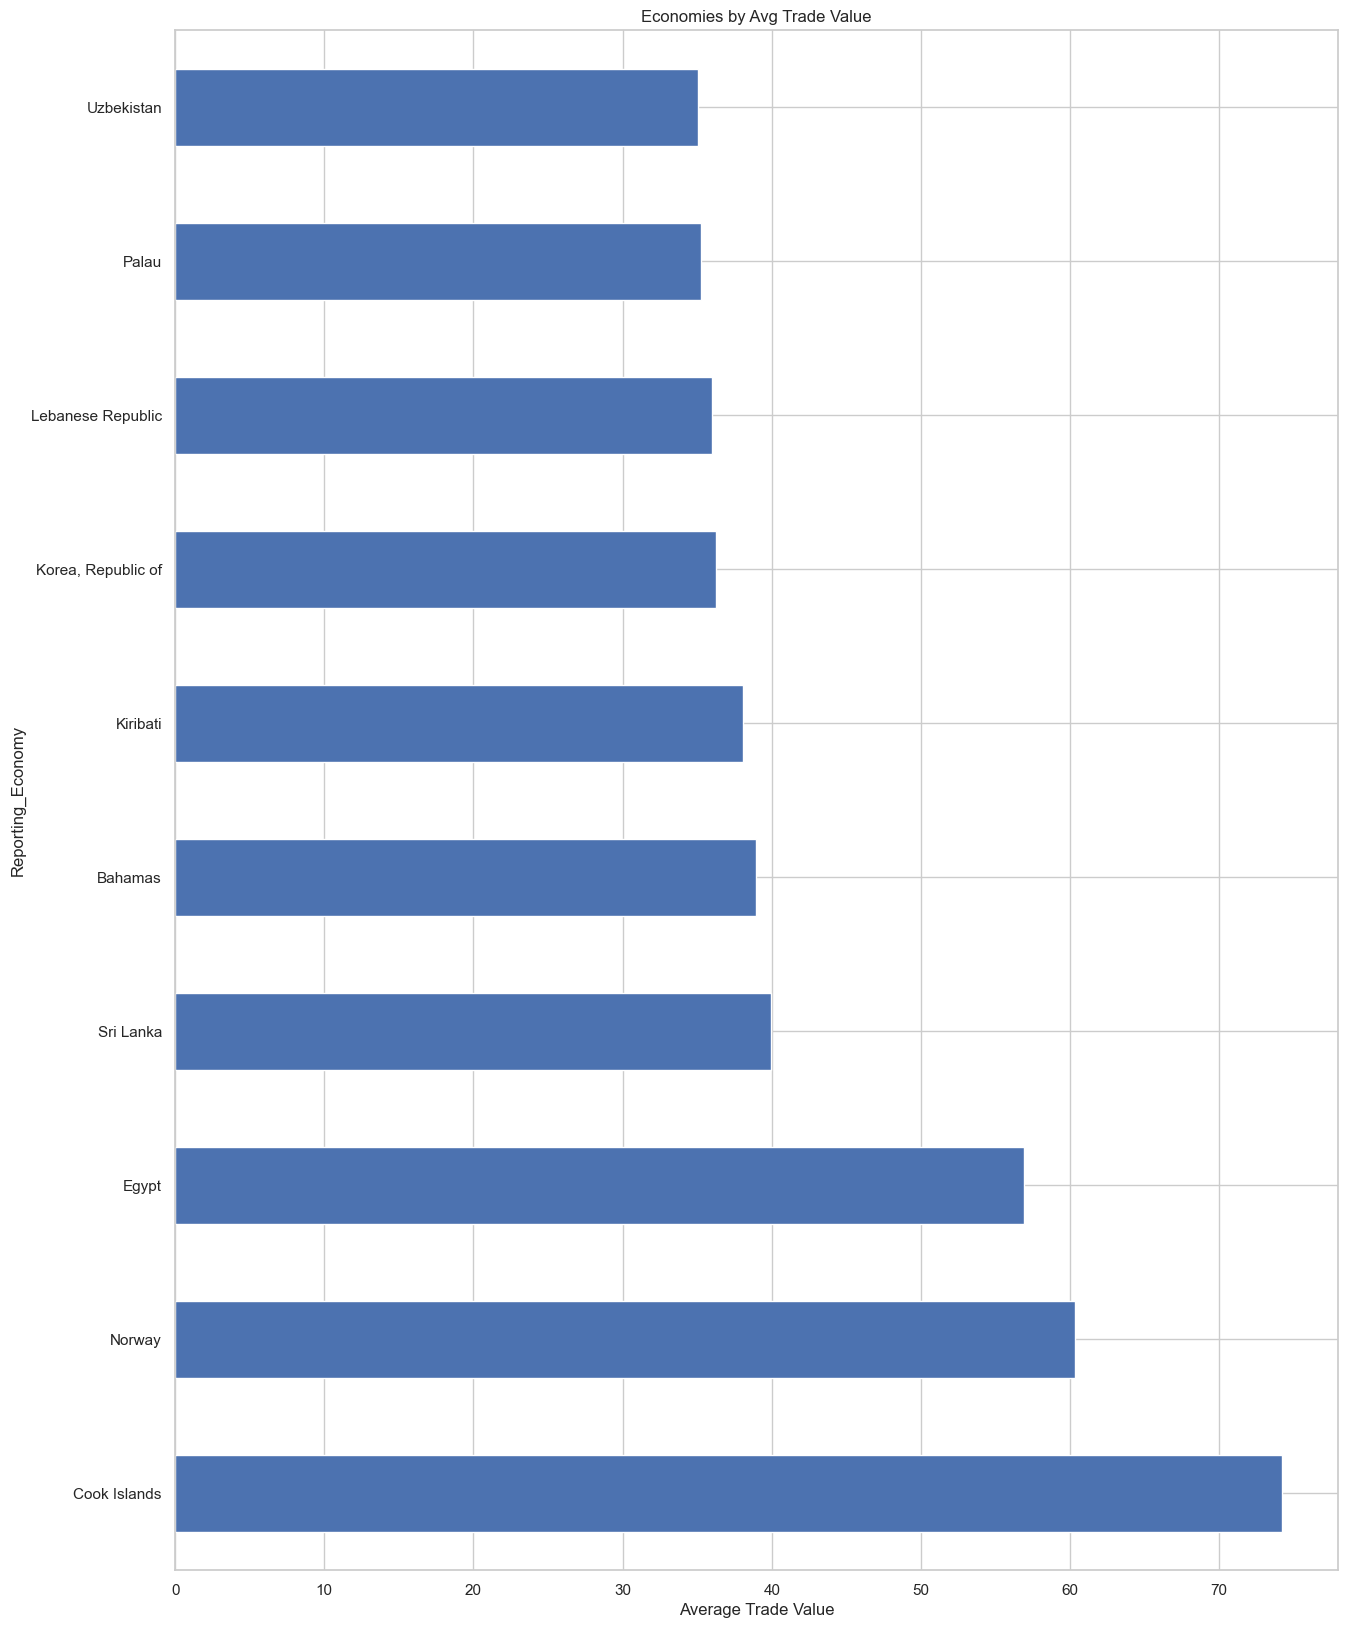

In [35]:
# 5. Bar Plot: Average Value by Reporting Economy
avg_economy = df.groupby('Reporting_Economy')['Value'].mean().nlargest(10)
avg_economy.plot(kind='barh', figsize=(15,20))
plt.title("Economies by Avg Trade Value")
plt.xlabel("Average Trade Value")
plt.show()

### 🏛️ Bar Plot: Economies with Highest Average Tariff Values

This horizontal bar chart presents the **top 10 economies** with the **highest average tariff values**, based on WTO-reported trade data.


#### 📊 Key Insights:
- Highlights **economies with more protectionist trade policies** or consistently high tariff levels.
- Visualizes countries that may impose **barriers to entry** for foreign goods, potentially to protect local industries.
- Useful for identifying **outliers** in global tariff behavior that might impact trade negotiations or international relations.


#### 🧠 Why It Matters:
- Helps in evaluating **global trade fairness and market accessibility**.
- Supports analysts and policymakers in spotting **target regions for trade reform discussions**.
- Provides context for comparing **high-tariff economies vs. liberal economies** and their impact on global commerce.


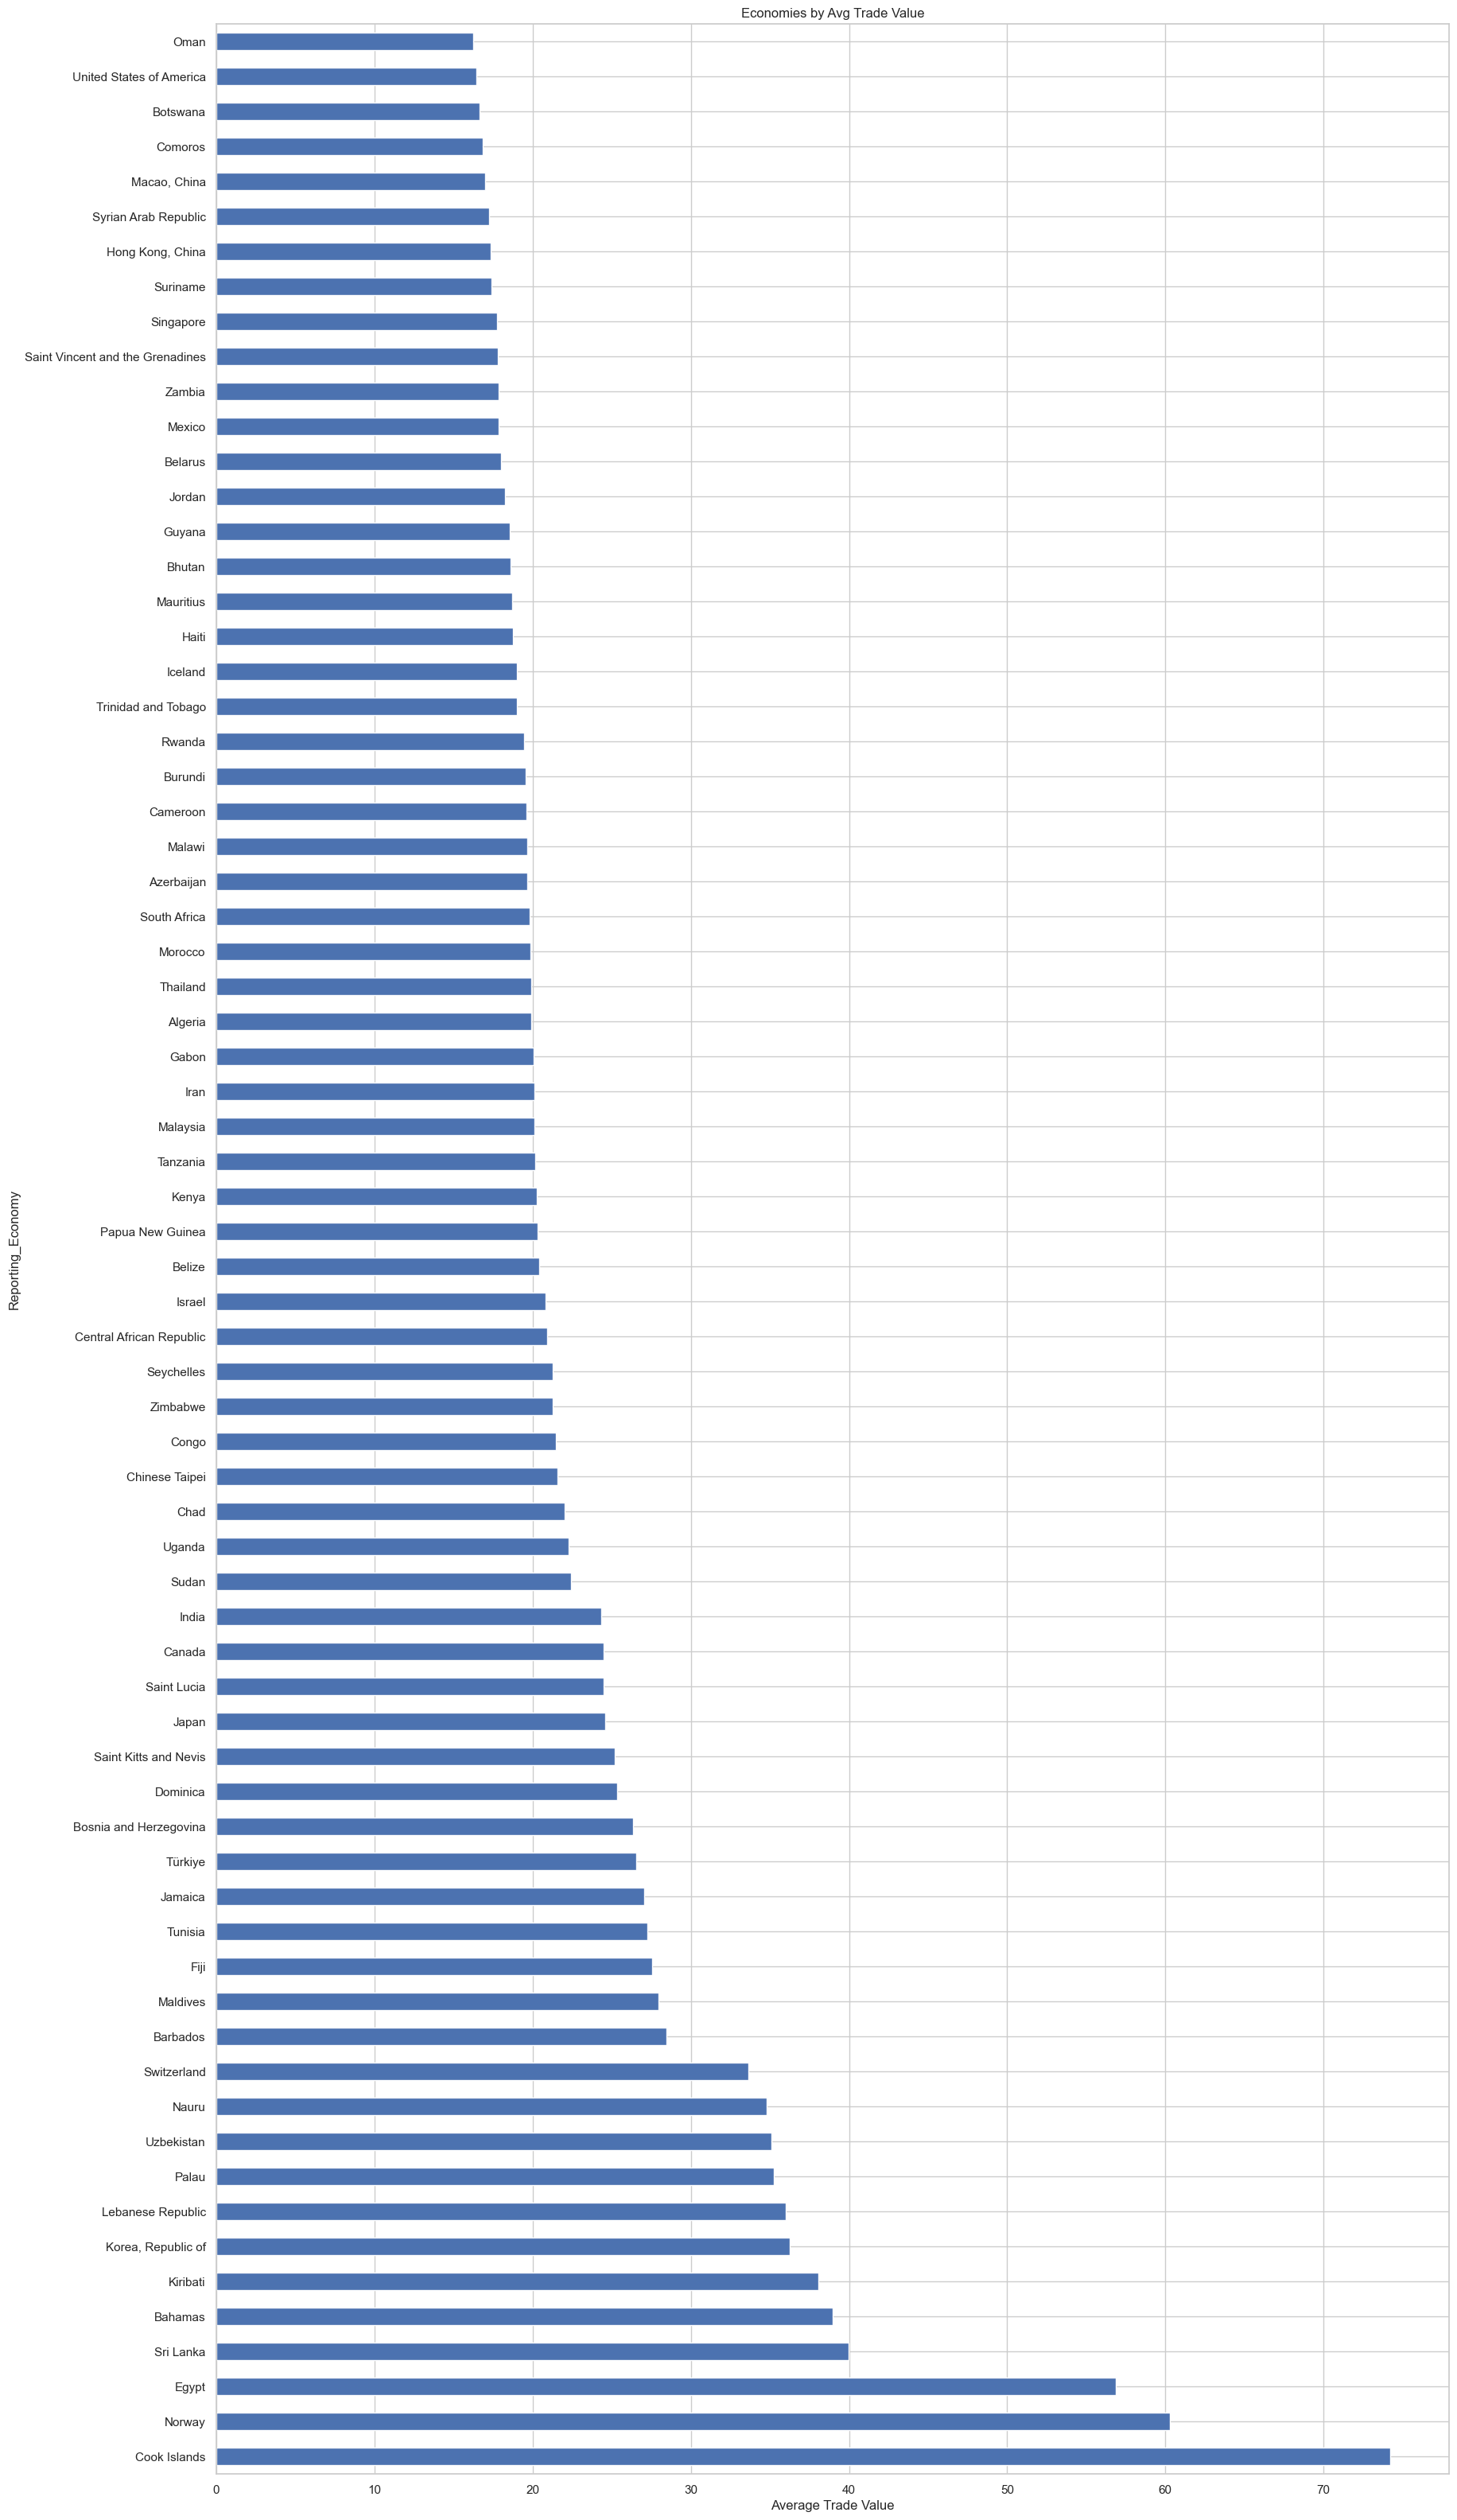

In [37]:
# 5. Bar Plot: Average Value by Reporting Economy
avg_economy = df.groupby('Reporting_Economy')['Value'].mean().nlargest(70)
avg_economy.plot(kind='barh', figsize=(20,40))
plt.title("Economies by Avg Trade Value")
plt.xlabel("Average Trade Value")
plt.show()

### 🌍 Bar Plot: Top 70 Economies by Average Tariff Value

This extended horizontal bar chart showcases the **top 70 economies** ranked by their **average tariff values**, calculated from WTO-reported data.


#### 📊 Key Insights:
- Offers a **broader global view** of how average tariffs are distributed across a wide range of countries.
- Enables identification of **clusters of high-tariff economies** as well as those with **moderate trade barriers**.
- The distribution helps reveal **regional policy patterns** or **trade bloc similarities**.


#### 🧠 Why It Matters:
- Enhances **comparative policy analysis**


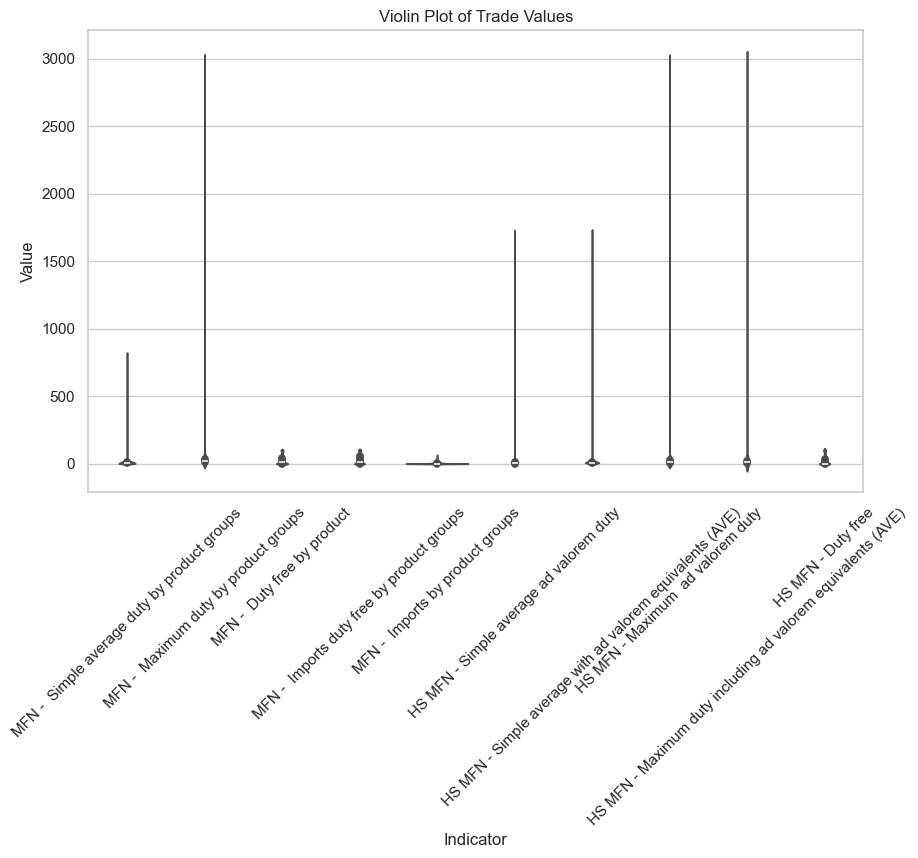

In [38]:
# 6. Violin Plot of Value by Indicator
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Indicator', y='Value')
plt.title("Violin Plot of Trade Values")
plt.xticks(rotation=45)
plt.show()

### 🎻 Violin Plot: Distribution of Trade Values by Indicator

This violin plot visualizes the **distribution and density** of tariff values across different trade **indicators**.


#### 📊 Key Insights:
- Combines a **box plot** with a **kernel density estimate**, providing both **summary statistics** and **data distribution shape**.
- The **width of each "violin"** indicates where the data is more concentrated (wider = more values).
- The **white dot** represents the **median**, while the **thick bar** shows the **interquartile range (IQR)**.


#### 🔍 Observations:
- Some indicators show **bimodal or skewed distributions**, suggesting varying trade policies across reporting economies.
- **Outliers and spread** can be quickly identified, helping detect **volatility or inconsistency** in tariff applications.
- Compact violins indicate **uniform policies**, while wider violins suggest **diverse implementations**.


#### 🧠 Why It Matters:
- Useful for detecting **policy uncertainty**, **distributional anomalies**, or **non-normality** in tariff values.
- Helps choose appropriate **statistical models** (e.g., Poisson or non-parametric) based on data shape.
- Enables focused investigation into **which indicators exhibit greater dispersion or policy experimentation**.


This plot provides both **depth and detail**—ideal for exploratory data analysis and modeling preparation.


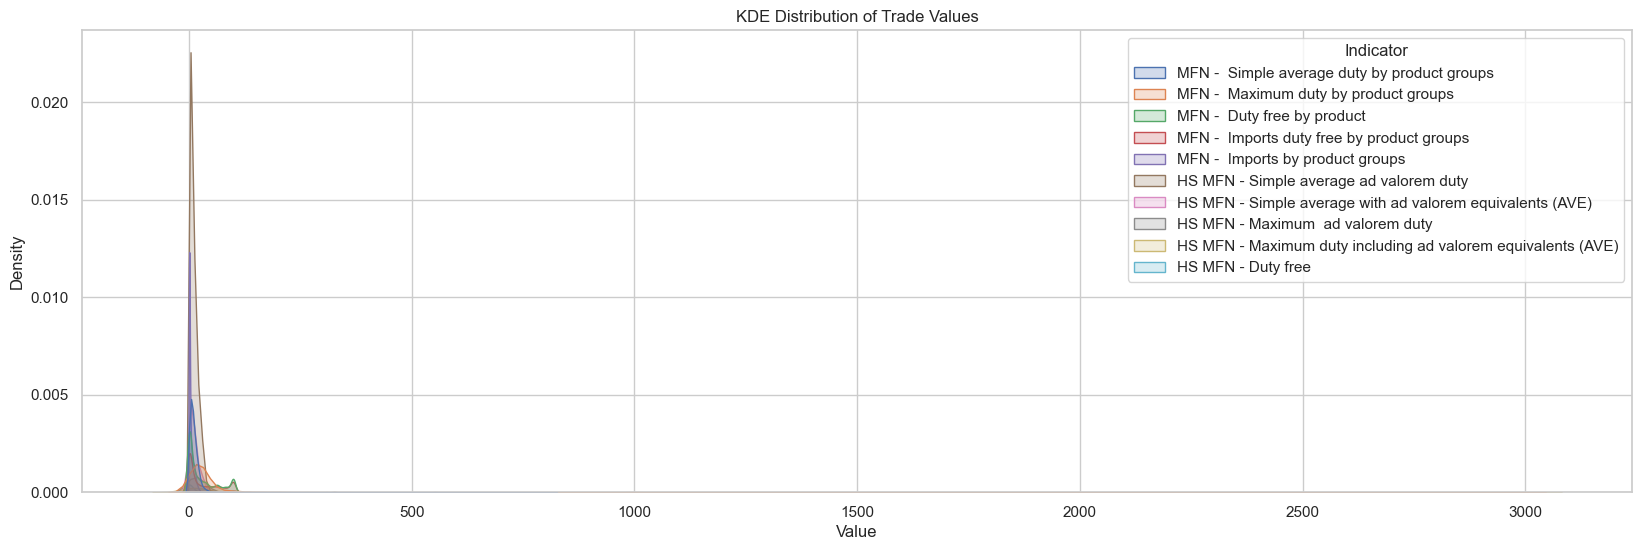

In [40]:
# 7. KDE Plot by Indicator
plt.figure(figsize=(20, 6))
sns.kdeplot(data=df, x='Value', hue='Indicator', fill=True)
plt.title("KDE Distribution of Trade Values")
plt.show()

### 🌊 KDE Plot: Distribution of Trade Values by Indicator

This KDE (Kernel Density Estimate) plot illustrates the **smoothed distribution** of tariff values for different **trade indicators**, allowing for intuitive comparison across categories.


#### 📊 Key Insights:
- Each curve represents the **probability density** of trade values for a specific indicator.
- **Filled areas** enhance visibility, helping identify **overlaps, peaks, and spread**.
- KDE offers a **continuous view** of the data distribution, making it easier to spot **central tendencies** and **distributional differences**.


#### 🔍 Observations:
- Peaks show where **trade values are most concentrated** for each indicator.
- Wide spreads or **multiple peaks (multimodal distributions)** indicate variability in how tariffs are applied across countries.
- Some indicators may show **sharp, narrow peaks**, suggesting **consistent policies**, while flatter curves suggest **diversity or volatility**.


#### 🧠 Why It Matters:
- Ideal for detecting **subtle patterns** that box plots or histograms might miss.
- Helps in selecting or validating **assumptions for statistical modeling** (e.g., normality, skewness).
- Provides a **comparative view of policy behavior** across indicators, supporting deeper exploration.


This KDE plot is a powerful visualization for understanding the **underlying structure** and **spread** of tariff values in a continuous and comparative format.


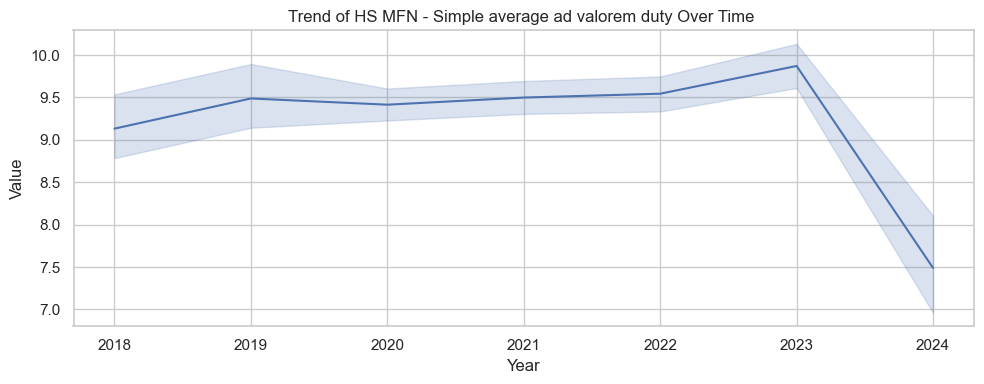

In [41]:
# 7: Line Plot for Indicator 2

indicator = top_indicators[0]
data = df[df['Indicator'] == indicator]
plt.figure(figsize=(10, 4))
sns.lineplot(data=data, x='Year', y='Value', legend=False)
plt.title(f"Trend of {indicator} Over Time ")
plt.tight_layout()
plt.show()

### 📈 Line Plot: Trend of HS MFN - Simple average ad valorem duty Over Time

This line plot illustrates the **temporal trend** of a specific trade indicator — in this case, the **first in the top indicators list** — across the available years.


#### 📊 Key Insights:
- Captures how the **tariff values for one trade indicator** have changed over time.
- Helps identify **long-term patterns**, including **policy shifts**, **economic reforms**, or **external shocks** (e.g., global trade events).
- Smoothness or volatility in the line reveals the **consistency or fluctuation** in trade policy related to this indicator.


#### 🔍 Observations:
- A **downward trend** may signal **trade liberalization** or tariff reduction.
- An **upward trend** could point to **protectionist shifts** or adjustments for specific sectors/products.
- Periods of flat lines suggest **policy stability**, while sharp changes indicate **regulatory interventions**.


#### 🧠 Why It Matters:
- Supports **trend analysis** and **forecasting** for individual indicators.
- Useful for isolating the impact of **policy decisions on specific trade metrics**.
- Offers a **focused view** for deeper dives into one dimension of trade behavior.


This plot provides a clear timeline of **how a single trade measure has evolved**, setting the stage for more granular or comparative time-series analyses.


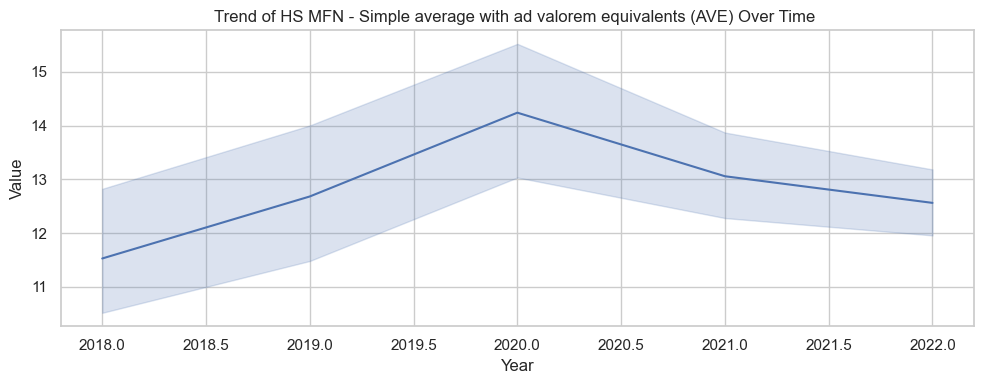

In [45]:
# 7: Line Plot for Indicator 2

indicator = top_indicators[1]
data = df[df['Indicator'] == indicator]
plt.figure(figsize=(10, 4))
sns.lineplot(data=data, x='Year', y='Value')
plt.title(f"Trend of {indicator} Over Time ")
plt.tight_layout()
plt.show()

### 📈 Line Plot: Trend of Trend of HS MFN - Simple average with ad valorem equivalents (AVE) Over Time

This line plot displays the **year-wise trend** of the second highest-frequency trade indicator, offering insights into how its **tariff values have evolved over time**.


#### 📊 Key Insights:
- Tracks the **temporal behavior** of a specific trade indicator reported by various economies.
- Helps assess whether there's a **progressive reduction**, **increase**, or **stagnation** in tariff levels.
- Multiple data points across years capture **policy changes**, **external shocks**, or **global trade alignments**.


#### 🔍 Observations:
- An **upward trajectory** may indicate growing **protectionism** or sector-specific tariffs.
- A **declining curve** typically reflects **liberalization efforts** or alignment with trade agreements.
- **Fluctuations** suggest inconsistent policy application or external factors affecting tariff decisions.


#### 🧠 Why It Matters:
- Offers a **focused analysis** of one


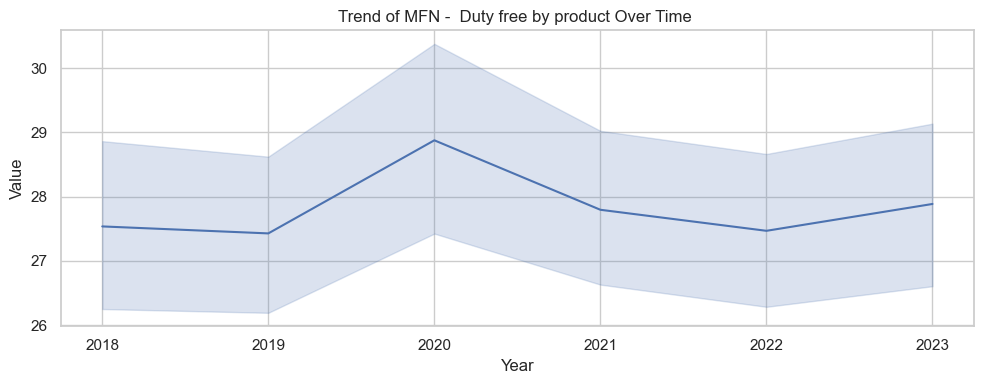

In [46]:
indicator = top_indicators[2]
data = df[df['Indicator'] == indicator]
plt.figure(figsize=(10, 4))
sns.lineplot(data=data, x='Year', y='Value')
plt.title(f"Trend of {indicator} Over Time ")
plt.tight_layout()
plt.show()

### 📈 Line Plot: Trend of MFN - Duty free by product Over Time

This line plot visualizes the **year-wise progression** of the third most frequent trade indicator in the dataset, shedding light on how its **average tariff values** have shifted over time.


#### 📊 Key Insights:
- Highlights how this specific trade measure has **changed across reporting years**, potentially reflecting shifts in **policy focus** or **global trade dynamics**.
- The line offers a visual narrative of **consistency, reform, or volatility** depending on its shape and trend.
- Serves as a snapshot of how this indicator interacts with **economic cycles**, trade negotiations, or regional changes.


#### 🔍 Observations:
- **Steady declines** often signal progressive **liberalization or trade**


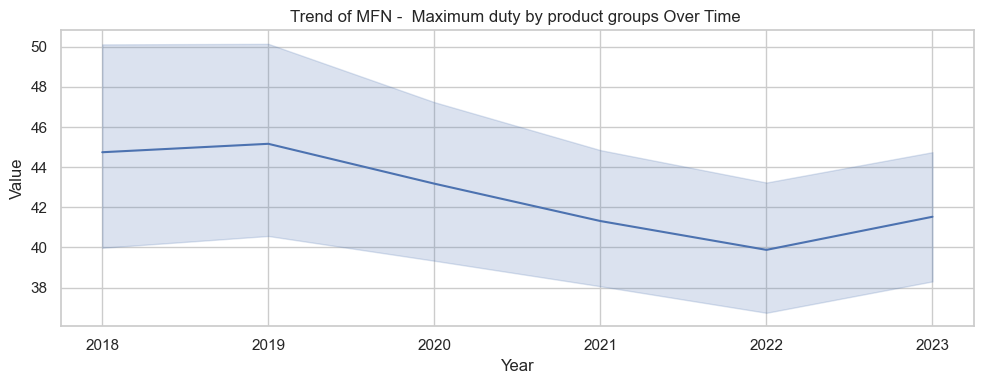

In [49]:
# 7: Line Plot for Indicator 2

indicator = top_indicators[3]
data = df[df['Indicator'] == indicator]
plt.figure(figsize=(10, 4))
sns.lineplot(data=data, x='Year', y='Value')
plt.title(f"Trend of {indicator} Over Time ")
plt.tight_layout()
plt.show()

### 📈 Line Plot: Trend of MFN - Maximum duty by product groups Over Time

This line chart illustrates the **year-over-year trend** for the fourth most reported trade indicator, providing insight into how **tariff values for this measure** have evolved over time.


#### 📊 Key Insights:
- Visualizes the **policy trajectory** associated with this specific trade indicator.
- Helps determine whether countries are moving toward **greater trade openness** or adopting **protectionist measures**.
- Detects **sudden spikes or dips** which may correspond to significant **trade reforms**, **political events**, or **economic crises**.


#### 🔍 Observations:
- **Consistent upward or downward slopes** may indicate a **clear policy direction**.
- **Volatile patterns** could point to **frequent regulatory shifts** or **external dependencies**.
- Clusters of changes around certain years may correlate with **multilateral agreements** or **global trade developments**.


#### 🧠 Why It Matters:
- Facilitates **longitudinal policy analysis** for this particular indicator.
- Aids in forecasting future trends and understanding **the ripple effect of trade decisions**.
- Enables policymakers and analysts to **benchmark progress or setbacks** in trade-related goals.


This visualization acts as a **time-based diagnostic tool**, tracking how one component of trade strategy unfolds across years and economies.


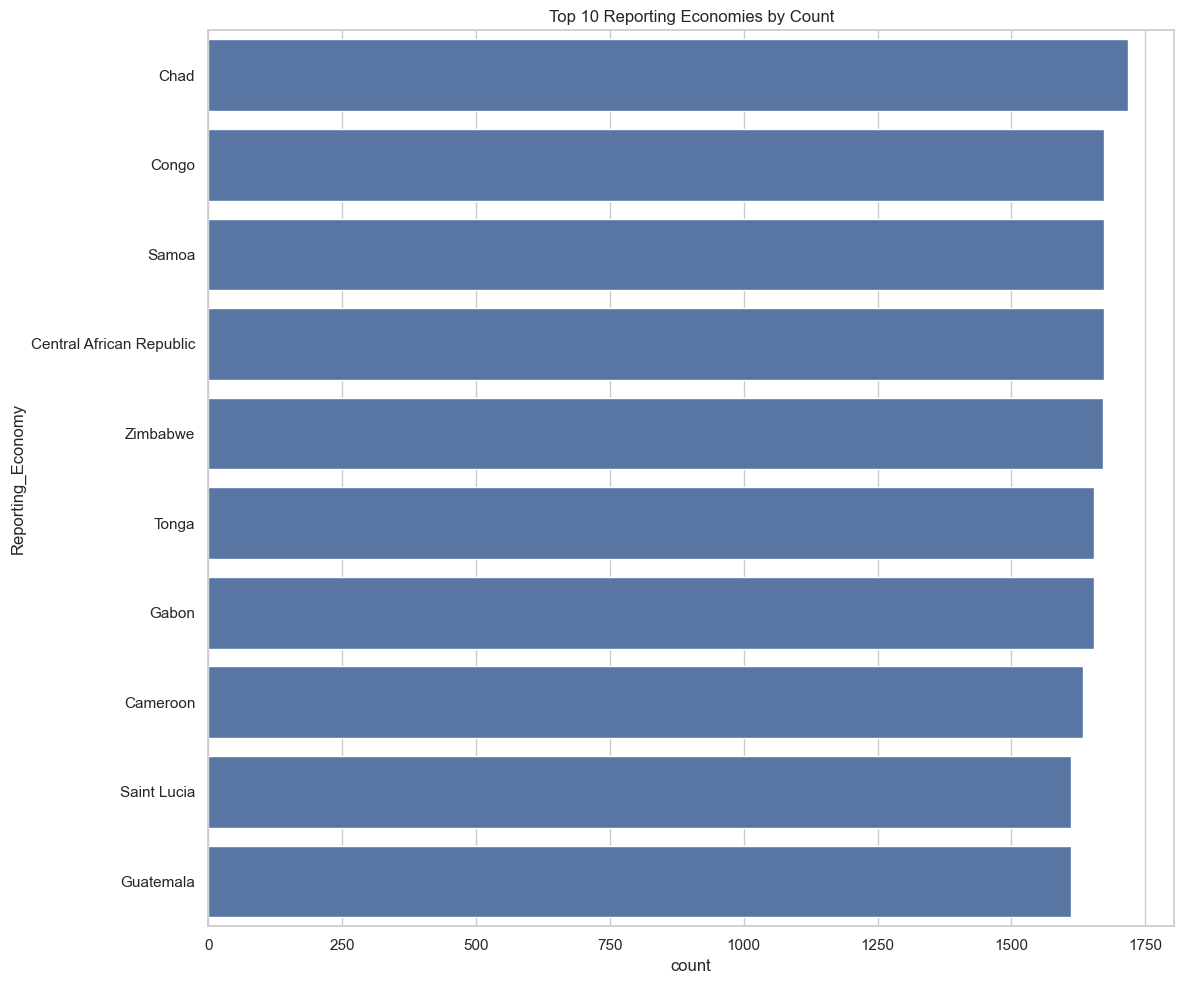

In [50]:
# 15. Count Plot of Reporting Economy
plt.figure(figsize=(12, 10))
sns.countplot(data=df, y='Reporting_Economy', order=df['Reporting_Economy'].value_counts().index[:10])
plt.title("Top 10 Reporting Economies by Count")
plt.tight_layout()
plt.show()

### 🏢 Count Plot: Top 10 Reporting Economies by Observation Count

This count plot displays the **top 10 economies** that have reported the most entries in the dataset, based on the frequency of their tariff records.


#### 📊 Key Insights:
- Highlights countries with the **most comprehensive reporting** or **active participation** in trade data submission.
- Helps identify economies that may have **more complete or reliable datasets** for advanced modeling.
- Useful for understanding **data density and potential bias** in the dataset toward certain countries.


#### 🔍 Observations:
- Economies at the top of the chart contribute **significantly more data points**, which can **enhance the accuracy** of trend analysis for those countries.
- Economies with fewer entries may offer **limited insights** or require **data imputation** in modeling.
- This visualization provides an **audit-like view** of data availability and participation levels.


#### 🧠 Why It Matters:
- Enables **transparent assessment of data coverage** across economies.
- Guides decisions on which countries to include in **comparative or time series analysis**.
- Ensures awareness of **data imbalance**, which is crucial for fair and representative statistical interpretations.


This plot serves as a **data quality checkpoint**, giving a quick overview of which countries dominate the dataset and how that might impact analysis outcomes.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a, sigma_y]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 184 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


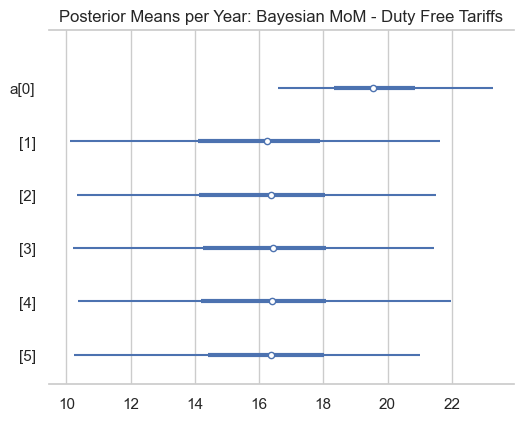

In [52]:
indicator_to_model = 'MFN -  Maximum duty by product groups'
sub_df = df[df['Indicator'] == indicator_to_model].copy()
sub_df = sub_df.head(50)
sub_df['Year'] = sub_df['Year'].astype(int).astype(str)  # Convert to categorical

# Encode year labels
year_codes, year_labels = pd.factorize(sub_df['Year'])
y = sub_df['Value'].values


with pm.Model() as mom_model:
    if len(y) == 0:
        raise ValueError("No data available for the selected indicator. Ensure 'y' is not empty.")

    # Hyperpriors for mean and standard deviation of group effects
    mu_a = pm.Normal('mu_a', mu=0, sigma=10)
    sigma_a = pm.HalfNormal('sigma_a', sigma=10)

    # Year-specific effects (random intercepts)
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=len(year_labels))

    # Observation error
    sigma_y = pm.HalfNormal('sigma_y', sigma=10)

    # Expected value per observation
    y_hat = a[year_codes]

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=y_hat, sigma=sigma_y, observed=y)

    # Sample posterior safely
    try:
        mom_trace = pm.sample(500, tune=500, target_accept=0.9, return_inferencedata=True)
    except ValueError as e:
        print("Sampling failed:", e)
        mom_trace = None

# Plot posterior distributions
az.plot_forest(mom_trace, var_names=["a"], combined=True)
plt.title("Posterior Means per Year: Bayesian MoM - Duty Free Tariffs")
plt.show()

### 🧠 Bayesian Mean-of-Means (MoM) Model: Year-wise Tariff Uncertainty

This model applies a **Bayesian hierarchical approach** to estimate year-specific average tariffs under the indicator  
**"MFN - Maximum duty by product groups"**, focusing on the first 50 records for demonstration.


#### 🧪 Model Summary:
- **Year effects** are treated as random intercepts to account for year-wise variability.
- The model captures **uncertainty and shrinkage** in the estimates, especially where data is sparse.
- Built using **PyMC**, this approach generates a **posterior distribution** of yearly means instead of point estimates.


#### 🔍 Components Explained:
- `mu_a`: Overall average tariff baseline (global mean).
- `sigma_a`: Spread of the year-specific deviations from the global mean.
- `a[i]`: Deviation of year *i* from the global mean.
- `sigma_y`: Noise or observation error around each predicted tariff value.
- `y_hat`: Predicted tariff per observation based on its year’s effect.


#### 📊 Visualization Insight:
- The **forest plot** shows the **posterior means and credibility intervals** for each year.
- Narrower intervals = **greater confidence** in the estimate.
- Wider intervals = **less data or more variability**.


#### 🧠 Why It Matters:
- Helps identify which years had **significantly higher or lower maximum duties**.
- Provides a **probabilistic understanding** of year-wise changes, useful for robust policy analysis.
- Demonstrates the strength of **Bayesian shrinkage**, avoiding overfitting in low-data scenarios.


This model gives a deeper, **uncertainty-aware view** of tariff trends, ideal for cases with **noisy or incomplete data** across time periods.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 64 seconds.


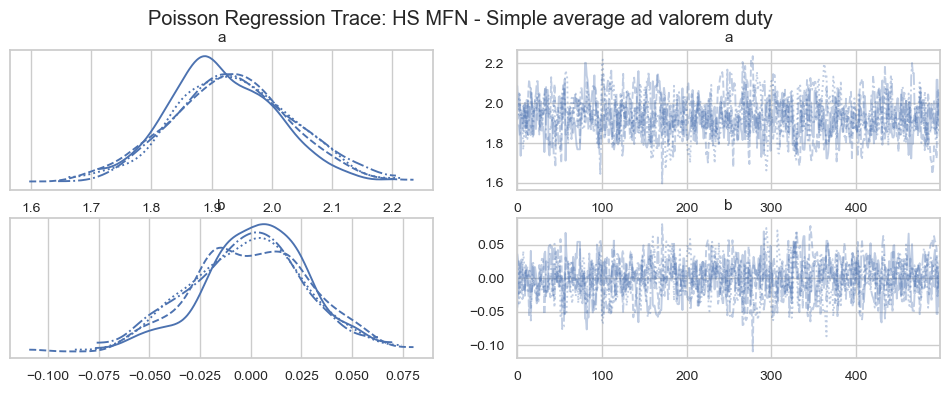

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 73 seconds.


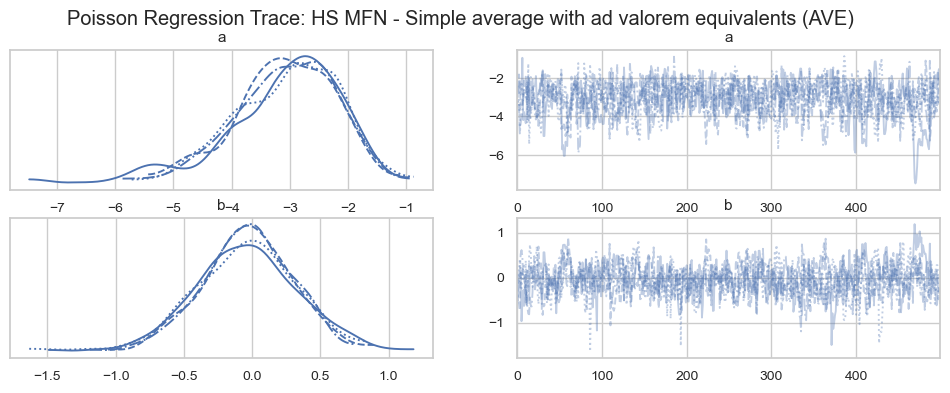

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 69 seconds.


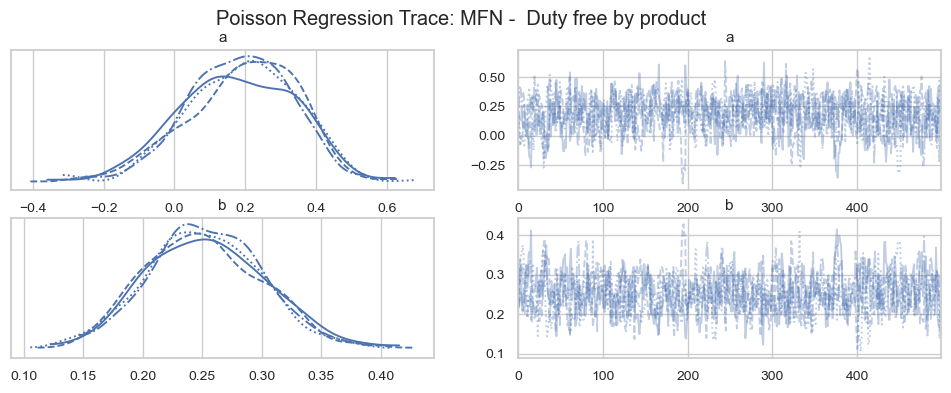

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 58 seconds.


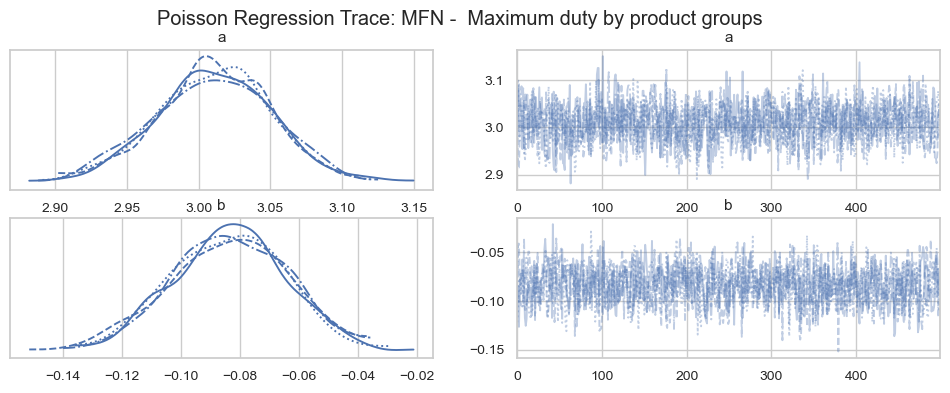

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 59 seconds.


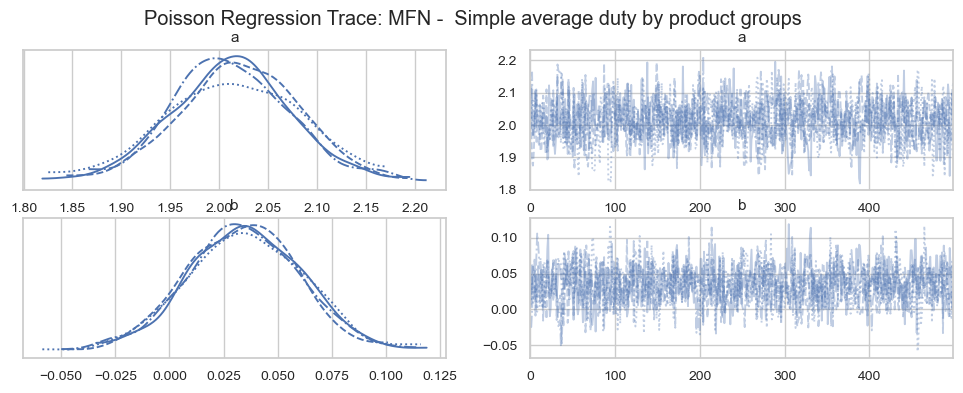

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 75 seconds.


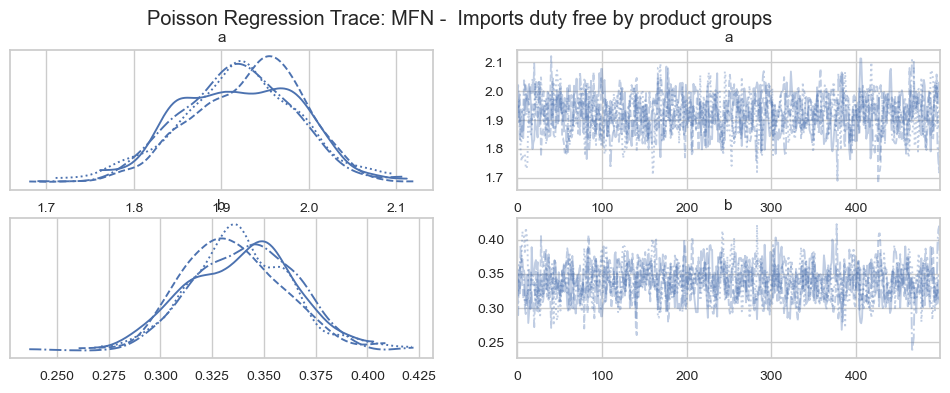

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 62 seconds.


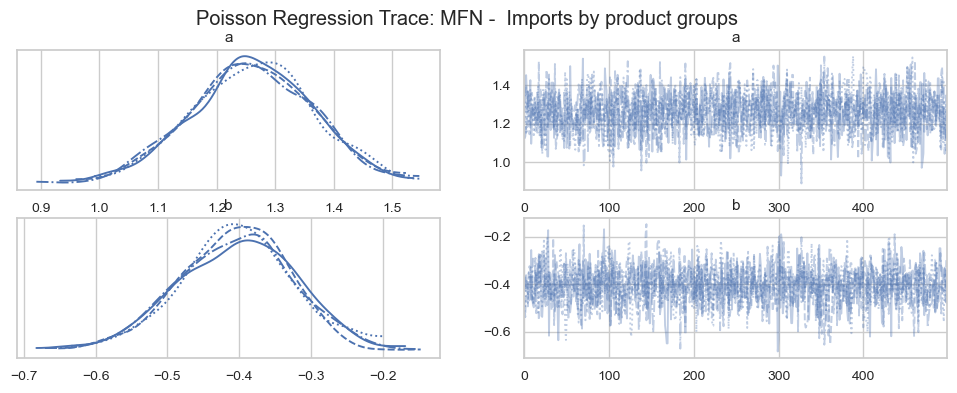

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 69 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


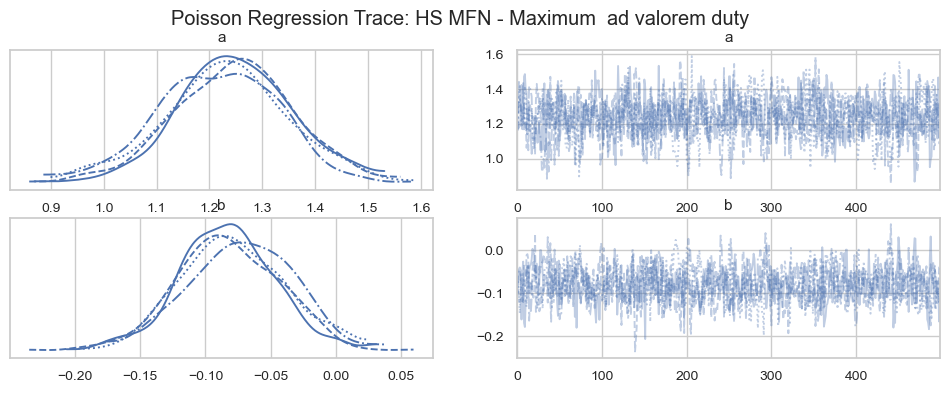

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 57 seconds.


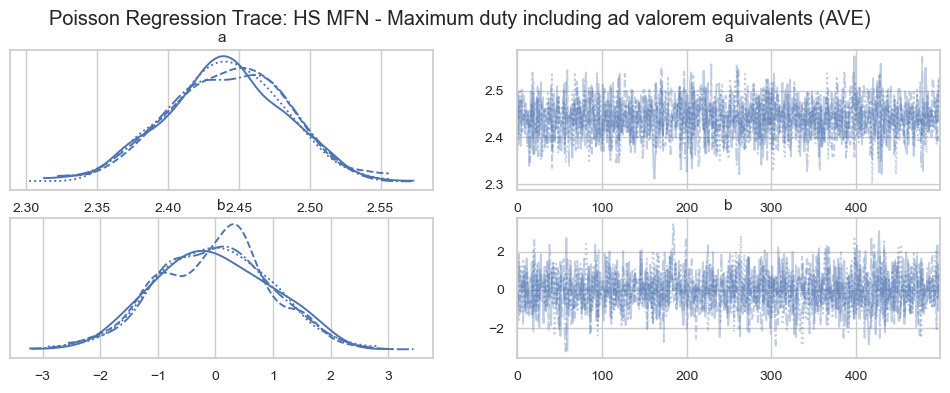

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 56 seconds.


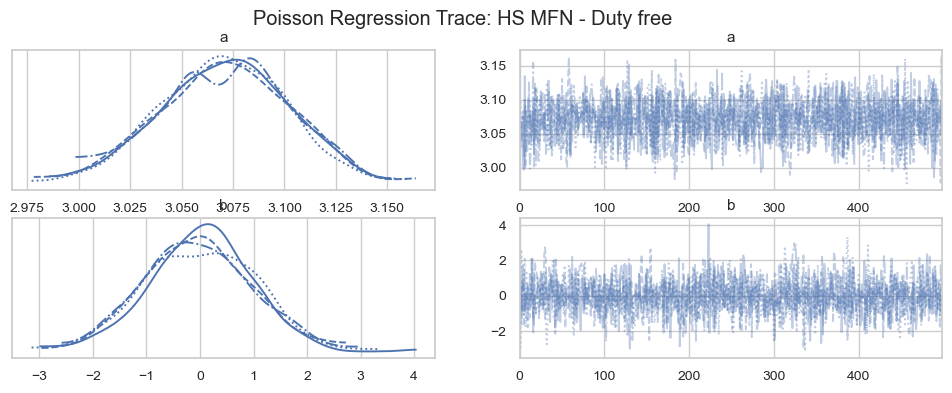

In [59]:
# Additional Poisson for up to 2 more indicators
for ind in top_indicators[0:10]:
    subset = df[df['Indicator'] == ind]
    subset=subset.head(50)

    if subset.shape[0] < 20:
        continue
    x_ = subset['Year'].values - subset['Year'].min()
    y_ = subset['Value'].astype(int).values
    with pm.Model() as model:
        a = pm.Normal("a", mu=0, sigma=10)
        b = pm.Normal("b", mu=0, sigma=1)
        mu = pm.math.exp(a + b * x_)
        obs = pm.Poisson("obs", mu=mu, observed=y_)
        trace = pm.sample(500, tune=500, return_inferencedata=True, progressbar=False)
        az.plot_trace(trace)
        plt.suptitle(f"Poisson Regression Trace: {ind}")
        plt.show()

<img src="Zach Galifianakis.gif" width="600" >
*When PyMC starts sampling and trace plots look like modern art...*


### 📈 Bayesian Poisson Regression: Modeling Trade Indicator Trends Over Time

This analysis applies **Bayesian Poisson regression** to the top 10 trade indicators (limited to first 50 records per indicator) to model **count-like or positively skewed trade value distributions** over time.


#### 🧪 Model Structure:
- **Model**: Poisson regression with log-link function:  
  \[
  \mu = \exp(a + b \cdot x)
  \]  
  where:
  - `a` is the intercept (baseline trade value)
  - `b` is the slope (rate of change over time)
  - `x` is the normalized year (time index)
- **Likelihood**: Observed trade values (`y`) are assumed to follow a **Poisson distribution**, appropriate for **non-negative skewed data**.


#### 🔍 Trace Plots:
- Generated for each indicator to visualize the **posterior distributions** of `a` and `b`.
- Help assess:
  - **Convergence** of chains (look for overlapping, stationary samples)
  - **Uncertainty** in parameter estimates
  - **Trends** (positive or negative) in tariff progression over years


#### 📊 Key Insights:
- A **positive `b` value** indicates a rising trend in trade value for that indicator.
- A **negative `b` value** suggests a decline over time.
- Indicators with flatter slopes reflect **stable policy environments**.


#### 🧠 Why It Matters:
- Offers a **probabilistic, time-sensitive model** for tariff behavior.
- Useful when trade values behave like **count data or exhibit skewness**.
- Supports **policy analysis** by estimating whether a trade metric is becoming more or less restrictive over time.


This approach allows for **robust modeling of multiple indicators** using **Bayesian techniques**, delivering deep insights into the **temporal dynamics of tariff structures**.


## 🔚 Final Strategic Conclusion

In conclusion, the data suggests that **global tariff structures are not liberalizing uniformly**—instead, countries are strategically reducing duties in non-sensitive sectors while maintaining protectionist walls around key industries.

- If **India and China** were to **form a selective free trade agreement**, particularly targeting low-risk agricultural and manufacturing imports, they could create a **dominant intra-Asian trade corridor** that circumvents Western dependence and tariff barriers.
- Meanwhile, the **United States risks falling behind**. Its static tariff categories and lack of significant downward movement, especially in MFN non-agricultural ranges, reveal **a stagnating trade policy** that may limit future negotiation leverage.

> **If Asia capitalizes on targeted liberalization while the West remains rigid, the balance of trade influence will shift East—one duty range at a time.**

The future of global trade won’t be shaped by sweeping WTO reforms but by **nimble, data-informed bilateral strategy**. In the tariff tug-of-war, agility will win—not ideology.


<h3>🎬 Thank you</h3>
<img src="denim kiss GIF by Pepe Jeans London.gif" width="400">
